# Remembered Object Position Task - Analysis - Part 2 - LMMs

## Data Import

In [1]:
# Load libraries
library('tidyverse')

library('lme4')
library('pwr')
library('emmeans')
library('parameters')
library('sjstats')
library('sjPlot')
library('lmerTest')
library('ggeffects')
library('buildmer')


# Folders
dir.data <- '../results'
dir.out <- dir.data


Warning message:
"package 'tidyverse' was built under R version 4.0.5"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.0.5"
Warning message:
"package 'tibble' was built under R version 4.0.5"
Warning message:
"package 'tidyr' was built under R version 4.0.5"
Warning message:
"package 'dplyr' was built under R version 4.0.5"
Warning message:
"package 'forcats' was built under R version 4.0.5"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

  

In [2]:
# Import datasets
trials <- read_tsv(paste(dir.data, '/lmm_analysis_trials.csv', sep='')) # Trial responses
trials_var <- read_tsv(paste(dir.data, '/lmm_analysis_stddev.csv', sep='')) # Aggregated SD values
tlx <- read_tsv(paste(dir.data, '/lmm_analysis_tlx.csv', sep='')) # NASA TLX scores

# Set factors
trials$response_mode <- factor(trials$response_mode, levels=c('object', 'cube', 'fixed', 'laser'))
trials$session_num <- factor(trials$session_num, levels=c(1, 2, 3, 4), order=T)
trials_var$response_mode <- factor(trials_var$response_mode, levels=c('object', 'cube', 'fixed', 'laser'))
trials_var$session_num <- factor(trials_var$session_num, levels=c(1, 2, 3, 4), order=T)
tlx$response_mode <- factor(tlx$response_mode, levels=c('object', 'cube', 'fixed', 'laser'))
tlx$session_num <- factor(tlx$session_num, levels=c(1, 2, 3, 4), order=T)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  experiment = col_character(),
  scene = col_character(),
  target = col_character(),
  response_mode = col_character(),
  preview_label = col_character(),
  target_label = col_character(),
  VR_move_location_0 = col_character(),
  Eye_gaze_location_0 = col_character(),
  invalid_reason = col_character(),
  trial_status = col_character(),
  drop1_err_pos = col_logical(),
  drop2_err_pos = col_logical(),
  drop3_err_pos = col_logical(),
  drop4_err_pos = col_logical()
)
i Use `spec()` for the full column specifications.


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  response_mode = col_character(),
  drop1_err_pos = col_logical(),
  drop2_err_pos = col_logical(),
  drop3_err_pos = col_logical(),
  drop4_err_pos = col_logical

## Model Selection


In [3]:
# Terms to include in all models evaluated by buildmer
force.include <- 'response_mode + session_num + response_mode:session_num + (1|ppid)'

### Accuracy

In [4]:
# Accuracy
max.acc <- tar_error_pos ~ response_mode + session_num + response_mode:session_num + (1 + response_mode + session_num|ppid) + (1+ response_mode + session_num|target)
#m.acc <- buildmer(max.acc, trials, buildmerControl=buildmerControl(include=force.include))

#print(formula(m.acc@model))
#print(m.acc)

# 0. buildmer ends on:
# tar_error_pos ~ 1 + response_mode + session_num + response_mode:session_num + (1 | ppid) + (1 + response_mode | target)
# REML criterion at convergence: -12858.88

# 1. Check if response_mode | ppid improves fit
#m0 <- lmer(data=trials, tar_error_pos ~ 1 + response_mode + session_num + response_mode:session_num + (1 | ppid) + (1 + response_mode | target), REML=F)
#m1 <- lmer(data=trials, tar_error_pos ~ 1 + response_mode + session_num + response_mode:session_num + (1 + response_mode | ppid) + (1 + response_mode | target), REML=F)
#print(anova(m0, m1))

# Result: Model with response_mode | ppid fits better
#    npar    AIC    BIC logLik deviance  Chisq Df Pr(>Chisq)    
# m0   28 -12968 -12800 6511.8   -13024                         
# m1   37 -13120 -12899 6597.0   -13194 170.49  9  < 2.2e-16 ***
# Note on negative logLik: https://stat.ethz.ch/pipermail/r-help/2005-April/069550.html


# 2. Check if including session_num | ppid improves fit
#m2 <- lmer(data=trials, tar_error_pos ~ 1 + response_mode + session_num + response_mode:session_num + (1 + response_mode + session_num | ppid) + (1 + response_mode | target), REML=F)

# Result: m2 does not converge


# 3. Check if session_num | target improves fit
#m3 <- lmer(data=trials, tar_error_pos ~ 1 + response_mode + session_num + response_mode:session_num + (1 + response_mode | ppid) + (1 + response_mode + session_num | target), REML=F)

# Result: m3 does not converge


# FINAL model for Accuracy: 
f.acc <- tar_error_pos ~ 1 + response_mode + session_num + response_mode:session_num + (1 + response_mode | ppid) + (1 + response_mode | target)


### Precision

In [5]:
# Precison (pre-aggregated by session)
max.prec <- tar_error_pos ~ response_mode + session_num + response_mode:session_num + (1 + response_mode + session_num | ppid)
#m.prec <- buildmer(max.prec, trials_var, buildmerControl=buildmerControl(include=force.include))

#print(formula(m.prec@model))

# 0. buildmer ends on:
# tar_error_pos ~ 1 + response_mode + session_num + response_mode:session_num + (1 | ppid)

# For all additional RE terms, observations <= random effects, no convergence

# FINAL model for Precision
f.prec <- tar_error_pos ~ 1 + response_mode + session_num + response_mode:session_num + (1 | ppid)


### Response Duration

In [6]:
# Response Duration
max.rt <- response_duration ~ response_mode + session_num + response_mode:session_num + (1 +  response_mode + session_num|ppid) + (1+ response_mode + session_num|target)
#m.rt <- buildmer(max.rt, trials, buildmerControl=buildmerControl(include=force.include))

#print(formula(m.rt@model))

# 0. buildmer ends on:
# response_duration ~ 1 + response_mode + session_num + response_mode:session_num + (1 | ppid) + (1 | target)


# 1. Check response_mode | ppid
m0 <- lmer(data=trials, response_duration ~ 1 + response_mode + session_num + response_mode:session_num + (1 | ppid) + (1 | target), REML=F)
#m1 <- lmer(data=trials, response_duration ~ 1 + response_mode + session_num + response_mode:session_num + (1 + response_mode | ppid) + (1 | target), REML=F)

# Result: m1 does not converge


# 2. Check session_num | ppid
m2 <- lmer(data=trials, response_duration ~ 1 + response_mode + session_num + response_mode:session_num + (1 + session_num | ppid) + (1 | target), REML=F)
#print(anova(m0, m2))

# Result: Model with session_num | ppid fits better
# m0   19 11146 11260 -5553.9    11108                         
# m2   28 10529 10696 -5236.5    10473 634.78  9  < 2.2e-16 ***

# 3. Check if session_num | target further improves fit
#m3 <- lmer(data=trials, response_duration ~ 1 + response_mode + session_num + response_mode:session_num + (1 + session_num | ppid) + (1 + session_num | target), REML=F)

# Result: m3 does not converge.

# 4. Check if response_mode | target further improves fit
#m4 <- lmer(data=trials, response_duration ~ 1 + response_mode + session_num + response_mode:session_num + (1 + session_num| ppid) + (1 + response_mode | target), REML=F)
#print(anova(m4, m2))

# Result: It does. 
# m2   28 10529 10696 -5236.5    10473                         
# m4   37 10439 10660 -5182.5    10365 107.94  9  < 2.2e-16 ***

# 5. Either adding "+ response_mode | ppid" or "+ session_num | target" fail to converge

# FINAL model for response duration: 
f.rt <- response_duration ~ 1 + response_mode + session_num + response_mode:session_num + (1 + session_num| ppid) + (1 + response_mode | target)


### TLX Score

In [7]:
# Subjective Workload
max.tlx <- Global ~ response_mode + session_num + response_mode:session_num + (1 + response_mode + session_num|ppid)
#m.tlx <- buildmer(max.tlx, tlx, buildmerControl=buildmerControl(include=force.include))
#print(formula(m.tlx@model))

# 0. buildmer ends on:
# Global ~ 1 + response_mode + session_num + response_mode:session_num + (1 | ppid)

# For all additional RE terms, observations <= random effects, no convergence

# FINAL model for TLX score
f.tlx <- Global ~ 1 + response_mode + session_num + response_mode:session_num + (1 | ppid)

## Final Models

### Accuracy

In [8]:
# Fit final model
model.acc <- lmer(data=trials, f.acc)

# Model + Anova results
cat('* ANOVA Omnibus Results + Statistics:\n')
print(summary(model.acc))
print(anova(model.acc))


* ANOVA Omnibus Results + Statistics:
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: f.acc
   Data: trials

REML criterion at convergence: -13048.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9638 -0.5886 -0.0900  0.4809  5.0118 

Random effects:
 Groups   Name               Variance  Std.Dev. Corr             
 target   (Intercept)        8.157e-05 0.009032                  
          response_modecube  4.864e-05 0.006974  0.06            
          response_modefixed 9.648e-05 0.009822 -0.09  0.15      
          response_modelaser 2.321e-04 0.015233 -0.54 -0.26  0.64
 ppid     (Intercept)        6.841e-05 0.008271                  
          response_modecube  8.697e-05 0.009326 -0.20            
          response_modefixed 3.249e-04 0.018024  0.03 -0.22      
          response_modelaser 1.162e-04 0.010779  0.01  0.16  0.53
 Residual                    5.963e-04 0.024418                  
Number of obs: 2932, grou


Correlation matrix not shown by default, as p = 16 > 12.
Use print(summary(model.acc), correlation=TRUE)  or
    vcov(summary(model.acc))        if you need it




Type III Analysis of Variance Table with Satterthwaite's method
                             Sum Sq   Mean Sq NumDF  DenDF F value    Pr(>F)
response_mode             0.0237301 0.0079100     3 16.603 13.2662 0.0001137
session_num               0.0030633 0.0010211     3 18.225  1.7125 0.1997241
response_mode:session_num 0.0120405 0.0013378     9 20.030  2.2437 0.0634328
                             
response_mode             ***
session_num                  
response_mode:session_num .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [9]:
# Post-hoc contrasts
cat('\n\n* Post-Hoc Comparisons for Response Mode:\n')
emm_response <- emmeans(model.acc, pairwise ~ response_mode, adjust="holm")
print(emm_response$contrasts)
print(eff_size(emm_response, sigma = sigma(model.acc), edf = df.residual(model.acc)))

cat('\n\n* Post-Hoc Comparisons for Session:\n')
print(emmeans(model.acc, pairwise ~ session_num, adjust="holm")$contrasts)




* Post-Hoc Comparisons for Response Mode:


NOTE: Results may be misleading due to involvement in interactions



 contrast       estimate      SE   df t.ratio p.value
 object - cube  -0.01281 0.00311 15.7 -4.119  0.0042 
 object - fixed -0.01625 0.00520 16.1 -3.124  0.0260 
 object - laser -0.02188 0.00460 23.8 -4.756  0.0005 
 cube - fixed   -0.00344 0.00621 16.0 -0.554  0.5871 
 cube - laser   -0.00906 0.00548 24.9 -1.655  0.3316 
 fixed - laser  -0.00562 0.00486 17.7 -1.157  0.5253 

Results are averaged over the levels of: session_num 
Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 6 tests 


Since 'object' is a list, we are using the contrasts already present.



 contrast         effect.size    SE   df lower.CL upper.CL
 (object - cube)       -0.525 0.128 15.7   -0.795   -0.254
 (object - fixed)      -0.666 0.213 16.1   -1.117   -0.214
 (object - laser)      -0.896 0.189 23.8   -1.286   -0.506
 (cube - fixed)        -0.141 0.254 16.0   -0.680    0.398
 (cube - laser)        -0.371 0.224 24.9   -0.833    0.091
 (fixed - laser)       -0.230 0.199 17.7   -0.649    0.188

Results are averaged over the levels of: session_num 
sigma used for effect sizes: 0.02442 
Degrees-of-freedom method: inherited from kenward-roger when re-gridding 
Confidence level used: 0.95 


* Post-Hoc Comparisons for Session:


NOTE: Results may be misleading due to involvement in interactions



 contrast estimate      SE   df t.ratio p.value
 1 - 2     0.00368 0.00448 21.8  0.822  1.0000 
 1 - 3     0.00169 0.00449 21.6  0.375  1.0000 
 1 - 4     0.00751 0.00430 18.7  1.745  0.5847 
 2 - 3    -0.00200 0.00430 18.8 -0.464  1.0000 
 2 - 4     0.00383 0.00448 21.8  0.854  1.0000 
 3 - 4     0.00582 0.00453 20.5  1.284  1.0000 

Results are averaged over the levels of: response_mode 
Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 6 tests 


In [10]:
# emmeans for plot
cat('\n\n* Estimated Marginal Means for Response:\n')
gemm.response <- ggemmeans(model.acc, terms=c('response_mode'))
write.csv(gemm.response, paste(dir.out, 'emmeans_acc_response.csv', sep='/'), row.names = FALSE)
gemm.response

cat('\n\n* Estimated Marginal Means for Session:\n')
gemm.session <- ggemmeans(model.acc, terms=c('session_num'))
write.csv(gemm.session, paste(dir.out, 'emmeans_acc_session.csv', sep='/'), row.names = FALSE)
gemm.session




* Estimated Marginal Means for Response:


NOTE: Results may be misleading due to involvement in interactions



x,predicted,std.error,conf.low,conf.high,group
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
object,0.03674621,0.003071520,0.03072614,0.04276628,1
cube,0.04955691,0.003974325,0.04176738,0.05734644,1
fixed,0.05299952,0.005876542,0.04148171,0.06451733,1
laser,0.05862162,0.004606887,0.04959229,0.06765095,1




* Estimated Marginal Means for Session:


NOTE: Results may be misleading due to involvement in interactions



x,predicted,std.error,conf.low,conf.high,group
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.05269921,0.003980093,0.04489837,0.06050005,1
2,0.04901888,0.003976334,0.04122541,0.05681235,1
3,0.05101391,0.003967206,0.04323833,0.05878949,1
4,0.04519226,0.003963689,0.03742357,0.05296095,1


$response_mode

$session_num


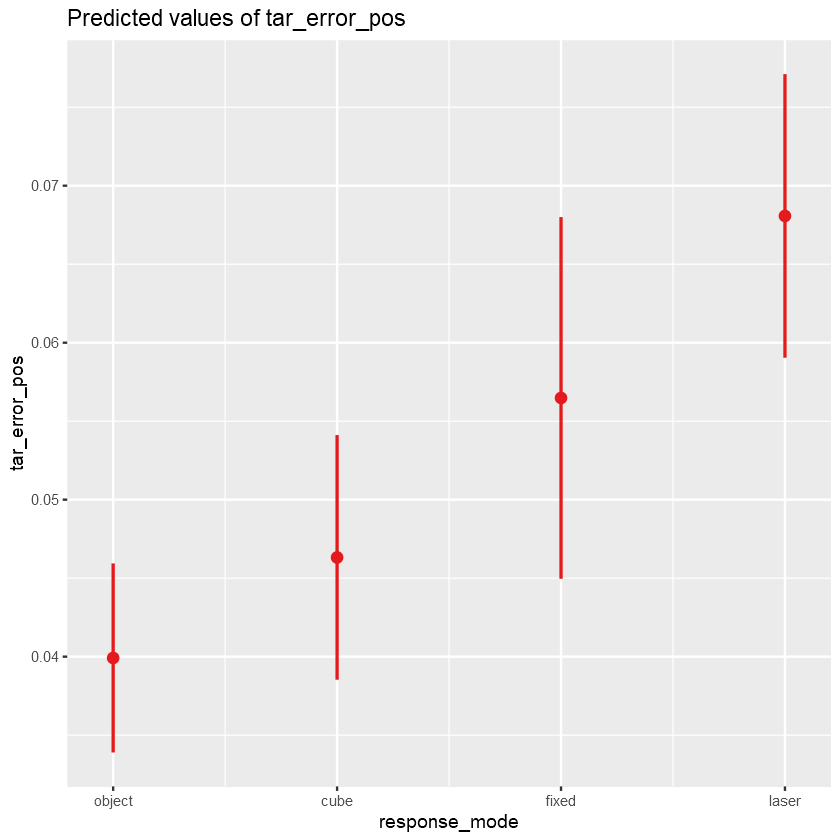

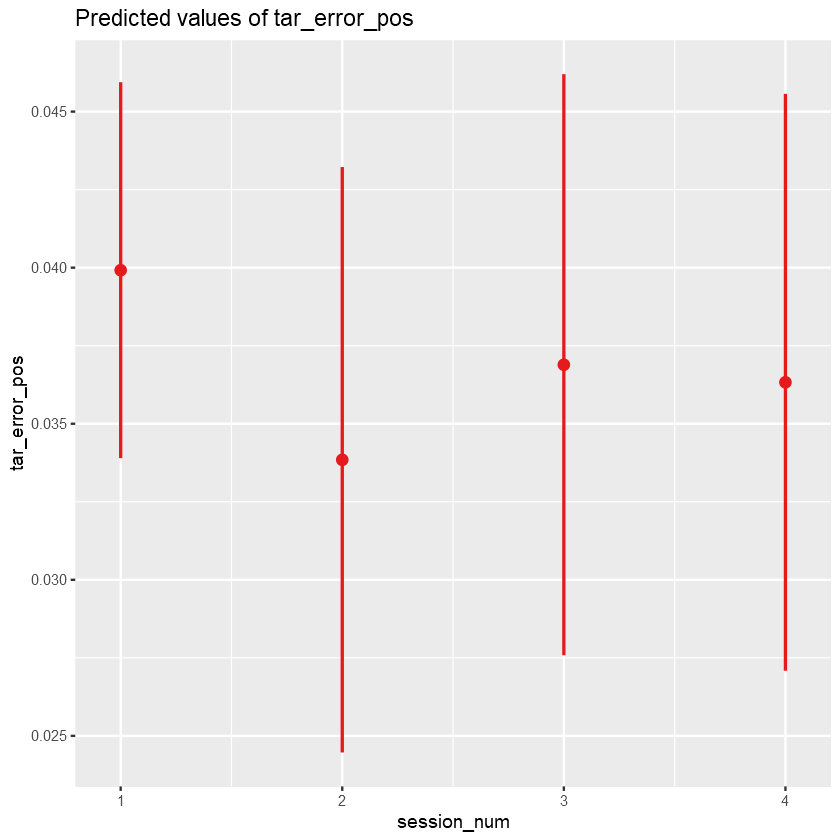

In [11]:
# Effects plots
plot_model(model.acc, type='pred')

### Precision

In [12]:
# Fit final model
model.prec <- lmer(data=trials_var, f.prec)

# Model + Anova results
cat('* ANOVA Omnibus Results + Statistics:\n')
print(summary(model.prec))
print(anova_stats(model.prec))


* ANOVA Omnibus Results + Statistics:
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: f.prec
   Data: trials_var

REML criterion at convergence: -300.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.81283 -0.49569 -0.05784  0.56699  2.40567 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ppid     (Intercept) 3.053e-05 0.005526
 Residual             4.373e-05 0.006613
Number of obs: 64, groups:  ppid, 16

Fixed effects:
                                   Estimate Std. Error         df t value
(Intercept)                       0.0184607  0.0021544 34.9136685   8.569
response_modecube                 0.0051094  0.0023380 33.7656609   2.185
response_modefixed                0.0070626  0.0023380 33.7656609   3.021
response_modelaser                0.0148544  0.0023380 33.7656609   6.353
session_num.L                    -0.0006192  0.0037628 42.9626294  -0.165
session_num.Q                     0.0012589  0.00376


Correlation matrix not shown by default, as p = 16 > 12.
Use print(summary(model.prec), correlation=TRUE)  or
    vcov(summary(model.prec))        if you need it


Warning message in tidy.anova(model):
"The following column names in ANOVA output were not recognized or transformed: NumDF, DenDF"


term                      | sumsq | meansq | NumDF |  DenDF | statistic | p.value | df | etasq | partial.etasq | omegasq | partial.omegasq | epsilonsq | cohens.f | power
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
response_mode             | 0.002 |  0.001 |     3 | 33.766 |    13.907 |  < .001 |    | 0.447 |         0.524 |         |                 |           |    1.050 |      
session_num               | 0.000 |  0.000 |     3 | 33.766 |     2.303 |   0.095 |    | 0.074 |         0.154 |         |                 |           |    0.427 |      
response_mode:session_num | 0.000 |  0.000 |     9 | 42.333 |     0.758 |   0.654 |    | 0.073 |         0.153 |         |                 |           |    0.425 |      
Residuals                 | 0.002 |  0.000 |       |        |           |         | 64 |       |               |         |                 |          

In [13]:
# Post-hoc contrasts
cat('\n\n* Post-Hoc Comparisons for Response Mode:\n')
emm_response <- emmeans(model.prec, pairwise ~ response_mode, adjust="holm")
print(emm_response$contrasts)
print(eff_size(emm_response, sigma = sigma(model.prec), edf = df.residual(model.prec)))

cat('\n\n* Post-Hoc Comparisons for Session:\n')
print(emmeans(model.prec, pairwise ~ session_num, adjust="holm")$contrasts)




* Post-Hoc Comparisons for Response Mode:


NOTE: Results may be misleading due to involvement in interactions



 contrast       estimate      SE   df t.ratio p.value
 object - cube  -0.00511 0.00234 33.2 -2.185  0.0721 
 object - fixed -0.00706 0.00234 33.2 -3.021  0.0145 
 object - laser -0.01485 0.00234 33.2 -6.353  <.0001 
 cube - fixed   -0.00195 0.00234 33.2 -0.835  0.4095 
 cube - laser   -0.00975 0.00234 33.2 -4.168  0.0010 
 fixed - laser  -0.00779 0.00234 33.2 -3.333  0.0085 

Results are averaged over the levels of: session_num 
Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 6 tests 


Since 'object' is a list, we are using the contrasts already present.



 contrast         effect.size    SE   df lower.CL upper.CL
 (object - cube)       -0.773 0.363 33.2    -1.51   -0.035
 (object - fixed)      -1.068 0.371 33.2    -1.82   -0.314
 (object - laser)      -2.246 0.424 33.2    -3.11   -1.384
 (cube - fixed)        -0.295 0.355 33.2    -1.02    0.427
 (cube - laser)        -1.474 0.385 33.2    -2.26   -0.689
 (fixed - laser)       -1.178 0.374 33.2    -1.94   -0.417

Results are averaged over the levels of: session_num 
sigma used for effect sizes: 0.006613 
Degrees-of-freedom method: inherited from kenward-roger when re-gridding 
Confidence level used: 0.95 


* Post-Hoc Comparisons for Session:


NOTE: Results may be misleading due to involvement in interactions



 contrast  estimate      SE   df t.ratio p.value
 1 - 2     0.005156 0.00234 33.2  2.205  0.1723 
 1 - 3     0.003438 0.00234 33.2  1.470  0.6035 
 1 - 4     0.005471 0.00234 33.2  2.340  0.1527 
 2 - 3    -0.001718 0.00234 33.2 -0.735  1.0000 
 2 - 4     0.000314 0.00234 33.2  0.134  1.0000 
 3 - 4     0.002033 0.00234 33.2  0.869  1.0000 

Results are averaged over the levels of: response_mode 
Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 6 tests 


In [14]:
# emmeans for plot
cat('\n\n* Estimated Marginal Means for Response:\n')
gemm.response <- ggemmeans(model.prec, terms=c('response_mode'))
write.csv(gemm.response, paste(dir.out, 'emmeans_prec_response.csv', sep='/'), row.names = FALSE)
gemm.response

cat('\n\n* Estimated Marginal Means for Session:\n')
gemm.session <- ggemmeans(model.prec, terms=c('session_num'))
write.csv(gemm.session, paste(dir.out, 'emmeans_prec_session.csv', sep='/'), row.names = FALSE)
gemm.session




* Estimated Marginal Means for Response:


NOTE: Results may be misleading due to involvement in interactions



x,predicted,std.error,conf.low,conf.high,group
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
object,0.01846072,0.002154434,0.01423810,0.02268333,1
cube,0.02357007,0.002154434,0.01934745,0.02779268,1
fixed,0.02552327,0.002154434,0.02130066,0.02974589,1
laser,0.03331510,0.002154434,0.02909248,0.03753771,1




* Estimated Marginal Means for Session:


NOTE: Results may be misleading due to involvement in interactions



x,predicted,std.error,conf.low,conf.high,group
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.02873352,0.002154434,0.02451091,0.03295613,1
2,0.02357721,0.002154434,0.01935460,0.02779982,1
3,0.02529565,0.002154434,0.02107304,0.02951827,1
4,0.02326277,0.002154434,0.01904016,0.02748538,1


$response_mode

$session_num


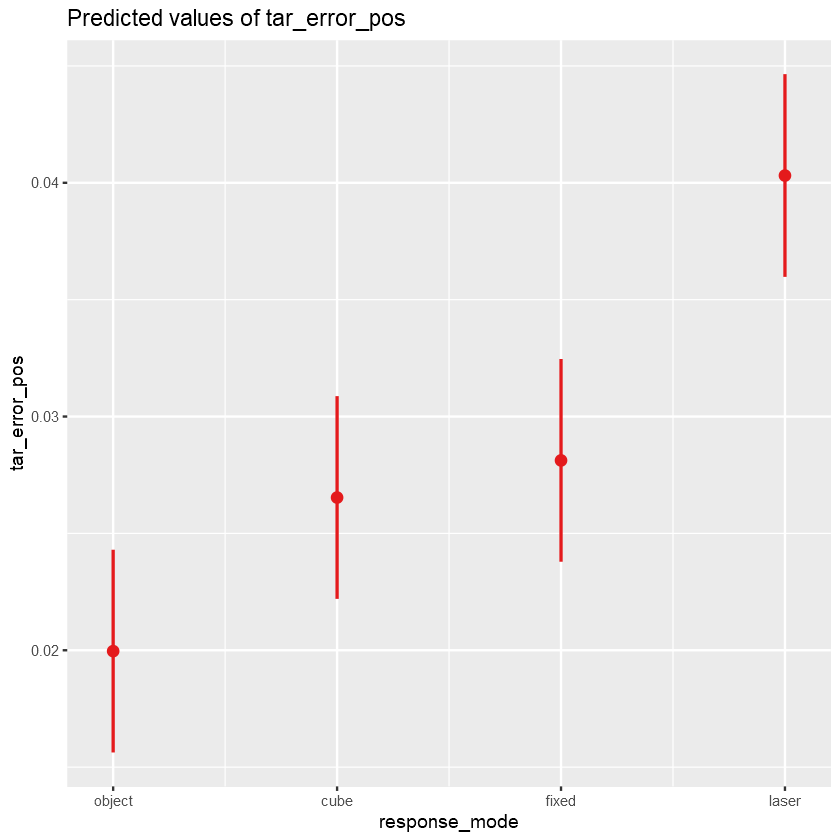

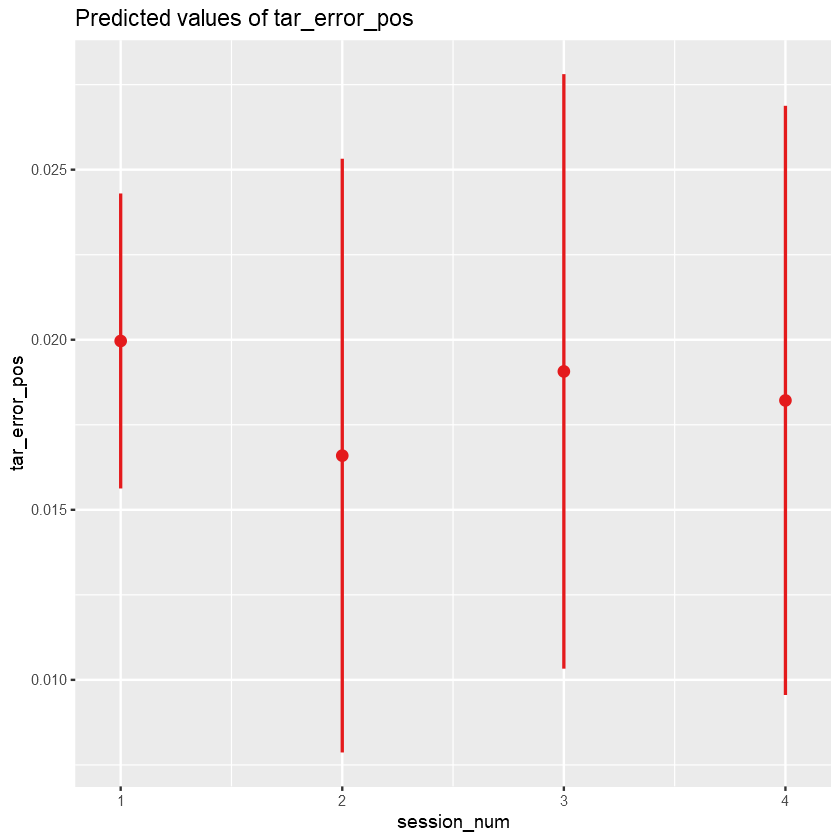

In [15]:
# Effects plots
plot_model(model.prec, type='pred')

### Response Duration

In [16]:
# Fit final model
model.rt <- lmer(data=trials, f.rt)

# Model + Anova results
cat('* ANOVA Omntrials_varsults + Statistics:\n')
print(summary(model.rt))
print(anova_stats(model.rt))


* ANOVA Omntrials_varsults + Statistics:
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: f.rt
   Data: trials

REML criterion at convergence: 10367.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0733 -0.4839 -0.1396  0.3007  7.0792 

Random effects:
 Groups   Name               Variance Std.Dev. Corr             
 target   (Intercept)        0.7244   0.8511                    
          response_modecube  0.3039   0.5513   -0.83            
          response_modefixed 0.4480   0.6693   -0.91  0.91      
          response_modelaser 0.5962   0.7721   -0.98  0.83  0.96
 ppid     (Intercept)        1.0164   1.0082                    
          session_num.L      0.9298   0.9643    0.38            
          session_num.Q      1.7768   1.3330   -0.09 -0.24      
          session_num.C      0.7552   0.8690    0.21  0.75 -0.15
 Residual                    1.8217   1.3497                    
Number of obs: 2932, groups:  targ


Correlation matrix not shown by default, as p = 16 > 12.
Use print(summary(model.rt), correlation=TRUE)  or
    vcov(summary(model.rt))        if you need it


Warning message in tidy.anova(model):
"The following column names in ANOVA output were not recognized or transformed: NumDF, DenDF"


term                      |    sumsq |  meansq | NumDF |  DenDF | statistic | p.value |   df | etasq | partial.etasq | omegasq | partial.omegasq | epsilonsq | cohens.f | power
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
response_mode             |  532.110 | 177.370 |     3 | 26.485 |    97.365 |  < .001 |      | 0.093 |         0.093 |         |                 |           |    0.321 |      
session_num               |    2.611 |   0.870 |     3 | 10.579 |     0.478 |   0.704 |      | 0.000 |         0.001 |         |                 |           |    0.022 |      
response_mode:session_num |   18.903 |   2.100 |     9 | 18.034 |     1.153 |   0.379 |      | 0.003 |         0.004 |         |                 |           |    0.061 |      
Residuals                 | 5160.955 |   1.760 |       |        |           |         | 2932 |       |               |  

In [17]:
# Post-hoc contrasts
cat('\n\n* Post-Hoc Comparisons for Response Mode:\n')
emm_response <- emmeans(model.rt, pairwise ~ response_mode, adjust="holm")
print(emm_response$contrasts)
print(eff_size(emm_response, sigma = sigma(model.rt), edf = df.residual(model.rt)))

cat('\n\n* Post-Hoc Comparisons for Session:\n')
print(emmeans(model.rt, pairwise ~ session_num, adjust="holm")$contrasts)




* Post-Hoc Comparisons for Response Mode:


NOTE: Results may be misleading due to involvement in interactions



 contrast       estimate    SE   df t.ratio p.value
 object - cube      1.47 0.401 26.7  3.669  0.0021 
 object - fixed     4.31 0.441 39.1  9.791  <.0001 
 object - laser     5.66 0.423 32.1 13.367  <.0001 
 cube - fixed       2.84 0.417 31.3  6.829  <.0001 
 cube - laser       4.19 0.394 26.0 10.628  <.0001 
 fixed - laser      1.34 0.371 19.4  3.623  0.0021 

Results are averaged over the levels of: session_num 
Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 6 tests 


Since 'object' is a list, we are using the contrasts already present.



 contrast         effect.size    SE   df lower.CL upper.CL
 (object - cube)        1.089 0.297 26.7    0.479     1.70
 (object - fixed)       3.197 0.329 39.1    2.531     3.86
 (object - laser)       4.192 0.318 32.1    3.543     4.84
 (cube - fixed)         2.108 0.310 31.3    1.476     2.74
 (cube - laser)         3.103 0.295 26.0    2.497     3.71
 (fixed - laser)        0.995 0.275 19.4    0.420     1.57

Results are averaged over the levels of: session_num 
sigma used for effect sizes: 1.35 
Degrees-of-freedom method: inherited from kenward-roger when re-gridding 
Confidence level used: 0.95 


* Post-Hoc Comparisons for Session:


NOTE: Results may be misleading due to involvement in interactions



 contrast estimate    SE    df t.ratio p.value
 1 - 2       0.572 0.483 12.02  1.183  1.0000 
 1 - 3       0.451 0.407 11.18  1.108  1.0000 
 1 - 4       0.305 0.408 10.76  0.747  1.0000 
 2 - 3      -0.121 0.233  9.61 -0.520  1.0000 
 2 - 4      -0.267 0.339 10.39 -0.787  1.0000 
 3 - 4      -0.146 0.401 11.13 -0.365  1.0000 

Results are averaged over the levels of: response_mode 
Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 6 tests 


In [18]:
# emmeans for plot
cat('\n\n* Estimated Marginal Means for Response:\n')
gemm.response <- ggemmeans(model.rt, terms=c('response_mode'))
write.csv(gemm.response, paste(dir.out, 'emmeans_rt_response.csv', sep='/'), row.names = FALSE)
gemm.response

cat('\n\n* Estimated Marginal Means for Session:\n')
gemm.session <- ggemmeans(model.rt, terms=c('session_num'))
write.csv(gemm.session, paste(dir.out, 'emmeans_rt_session.csv', sep='/'), row.names = FALSE)
gemm.session




* Estimated Marginal Means for Response:


NOTE: Results may be misleading due to involvement in interactions



x,predicted,std.error,conf.low,conf.high,group
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
object,7.594952,0.3741232,6.861684,8.328220,1
cube,6.124981,0.3389649,5.460622,6.789339,1
fixed,3.280350,0.3338271,2.626060,3.934639,1
laser,1.937238,0.3126210,1.324512,2.549964,1




* Estimated Marginal Means for Session:


NOTE: Results may be misleading due to involvement in interactions



x,predicted,std.error,conf.low,conf.high,group
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.066320,0.3397806,4.400362,5.732278,1
2,4.494401,0.3624844,3.783944,5.204857,1
3,4.615346,0.3397406,3.949467,5.281226,1
4,4.761453,0.3960140,3.985279,5.537626,1


$response_mode

$session_num


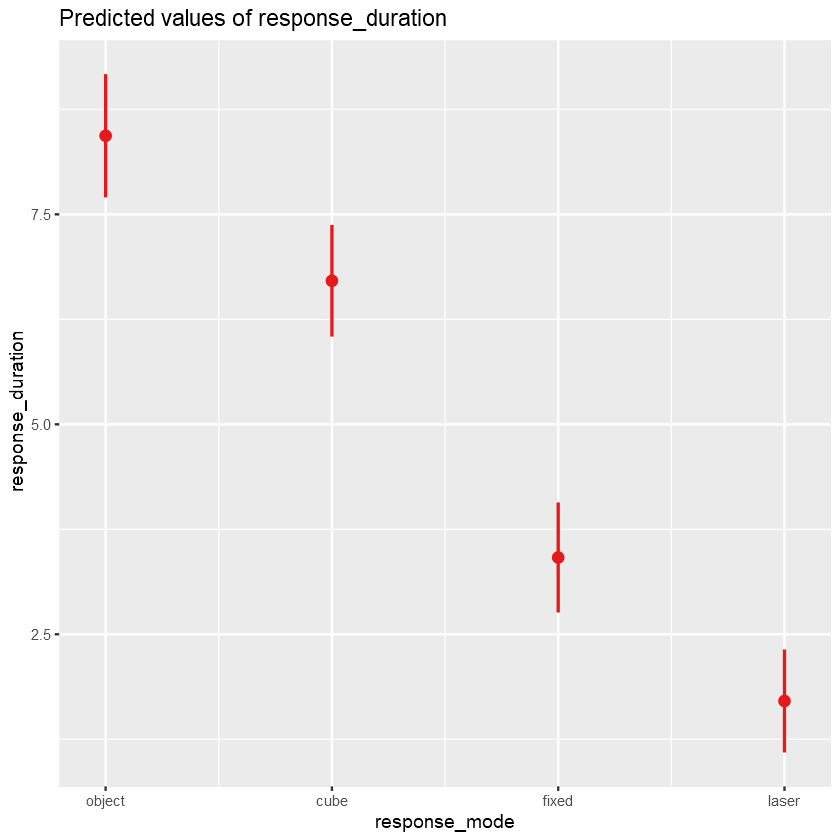

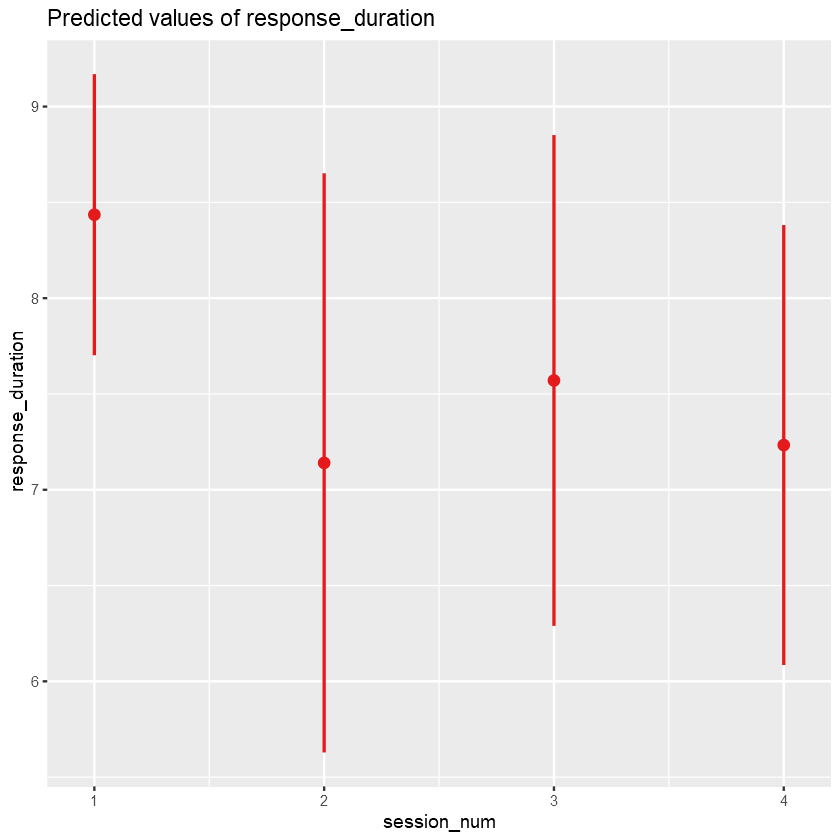

In [19]:
# Effects plots
plot_model(model.rt, type='pred')

### TLX Score

In [20]:
# Fit final model
model.tlx <- lmer(data=tlx, f.tlx)

# Model + Anova results
cat('* ANOVA Omntrials_varsults + Statistics:\n')
print(summary(model.tlx))
print(anova_stats(model.tlx))


* ANOVA Omntrials_varsults + Statistics:
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: f.tlx
   Data: tlx

REML criterion at convergence: 339.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.53817 -0.47114 -0.07449  0.55594  1.34442 

Random effects:
 Groups   Name        Variance Std.Dev.
 ppid     (Intercept) 87.12    9.334   
 Residual             15.86    3.983   
Number of obs: 64, groups:  ppid, 16

Fixed effects:
                                 Estimate Std. Error      df t value Pr(>|t|)
(Intercept)                       22.8125     2.5371 18.3173   8.992 3.86e-08
response_modecube                  2.3438     1.4082 32.8767   1.664 0.105550
response_modefixed                -5.8333     1.4082 32.8767  -4.142 0.000225
response_modelaser                -4.3229     1.4082 32.8767  -3.070 0.004274
session_num.L                     -4.6482     2.4265 35.1197  -1.916 0.063580
session_num.Q                     -2.


Correlation matrix not shown by default, as p = 16 > 12.
Use print(summary(model.tlx), correlation=TRUE)  or
    vcov(summary(model.tlx))        if you need it


Warning message in tidy.anova(model):
"The following column names in ANOVA output were not recognized or transformed: NumDF, DenDF"


term                      |   sumsq |  meansq | NumDF |  DenDF | statistic | p.value | df | etasq | partial.etasq | omegasq | partial.omegasq | epsilonsq | cohens.f | power
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
response_mode             | 687.196 | 229.065 |     3 | 32.877 |    14.439 |  < .001 |    | 0.374 |         0.561 |         |                 |           |    1.131 |      
session_num               | 451.519 | 150.506 |     3 | 32.877 |     9.487 |  < .001 |    | 0.245 |         0.456 |         |                 |           |    0.916 |      
response_mode:session_num | 163.233 |  18.137 |     9 | 34.690 |     1.143 |   0.360 |    | 0.089 |         0.233 |         |                 |           |    0.551 |      
Residuals                 | 537.584 |   8.400 |       |        |           |         | 64 |       |               |         |          

In [21]:
# Post-hoc contrasts
cat('\n\n* Post-Hoc Comparisons for Response Mode:\n')
emm_response <- emmeans(model.tlx, pairwise ~ response_mode, adjust="holm")
print(emm_response$contrasts)
print(eff_size(emm_response, sigma = sigma(model.tlx), edf = df.residual(model.tlx)))

cat('\n\n* Post-Hoc Comparisons for Session:\n')
print(emmeans(model.tlx, pairwise ~ session_num, adjust="holm")$contrasts)
print(eff_size(emmeans(model.tlx, pairwise ~ session_num, adjust="holm"), sigma = sigma(model.tlx), edf = df.residual(model.tlx)))



* Post-Hoc Comparisons for Response Mode:


NOTE: Results may be misleading due to involvement in interactions



 contrast       estimate   SE df t.ratio p.value
 object - cube     -2.34 1.41 33 -1.664  0.2110 
 object - fixed     5.83 1.41 33  4.142  0.0009 
 object - laser     4.32 1.41 33  3.070  0.0128 
 cube - fixed       8.18 1.41 33  5.807  <.0001 
 cube - laser       6.67 1.41 33  4.734  0.0002 
 fixed - laser     -1.51 1.41 33 -1.073  0.2912 

Results are averaged over the levels of: session_num 
Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 6 tests 


Since 'object' is a list, we are using the contrasts already present.



 contrast         effect.size    SE df lower.CL upper.CL
 (object - cube)       -0.588 0.359 33   -1.318    0.142
 (object - fixed)       1.465 0.385 33    0.681    2.248
 (object - laser)       1.085 0.371 33    0.330    1.841
 (cube - fixed)         2.053 0.413 33    1.212    2.894
 (cube - laser)         1.674 0.394 33    0.872    2.476
 (fixed - laser)       -0.379 0.356 33   -1.103    0.345

Results are averaged over the levels of: session_num 
sigma used for effect sizes: 3.983 
Degrees-of-freedom method: inherited from kenward-roger when re-gridding 
Confidence level used: 0.95 


* Post-Hoc Comparisons for Session:


NOTE: Results may be misleading due to involvement in interactions



 contrast estimate   SE df t.ratio p.value
 1 - 2        5.83 1.41 33  4.142  0.0011 
 1 - 3        3.23 1.41 33  2.293  0.0850 
 1 - 4        6.88 1.41 33  4.882  0.0002 
 2 - 3       -2.60 1.41 33 -1.849  0.1468 
 2 - 4        1.04 1.41 33  0.740  0.4647 
 3 - 4        3.65 1.41 33  2.589  0.0568 

Results are averaged over the levels of: response_mode 
Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 6 tests 


NOTE: Results may be misleading due to involvement in interactions

Since 'object' is a list, we are using the contrasts already present.



 contrast effect.size    SE df lower.CL upper.CL
 (1 - 2)        1.465 0.385 33   0.6810   2.2481
 (1 - 3)        0.811 0.364 33   0.0712   1.5503
 (1 - 4)        1.726 0.397 33   0.9189   2.5332
 (2 - 3)       -0.654 0.360 33  -1.3864   0.0787
 (2 - 4)        0.262 0.355 33  -0.4599   0.9830
 (3 - 4)        0.915 0.366 33   0.1703   1.6604

Results are averaged over the levels of: response_mode 
sigma used for effect sizes: 3.983 
Degrees-of-freedom method: inherited from kenward-roger when re-gridding 
Confidence level used: 0.95 


In [22]:
# emmeans for plot
cat('\n\n* Estimated Marginal Means for Response:\n')
gemm.response <- ggemmeans(model.tlx, terms=c('response_mode'))
write.csv(gemm.response, paste(dir.out, 'emmeans_tlx_response.csv', sep='/'), row.names = FALSE)
gemm.response

cat('\n\n* Estimated Marginal Means for Session:\n')
gemm.session <- ggemmeans(model.tlx, terms=c('session_num'))
write.csv(gemm.session, paste(dir.out, 'emmeans_tlx_session.csv', sep='/'), row.names = FALSE)
gemm.session




* Estimated Marginal Means for Response:


NOTE: Results may be misleading due to involvement in interactions



x,predicted,std.error,conf.low,conf.high,group
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
object,22.81250,2.537079,17.83992,27.78508,1
cube,25.15625,2.537079,20.18367,30.12883,1
fixed,16.97917,2.537079,12.00658,21.95175,1
laser,18.48958,2.537079,13.51700,23.46217,1




* Estimated Marginal Means for Session:


NOTE: Results may be misleading due to involvement in interactions



x,predicted,std.error,conf.low,conf.high,group
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,24.84375,2.537079,19.87117,29.81633,1
2,19.01042,2.537079,14.03783,23.98300,1
3,21.61458,2.537079,16.64200,26.58717,1
4,17.96875,2.537079,12.99617,22.94133,1


$response_mode

$session_num


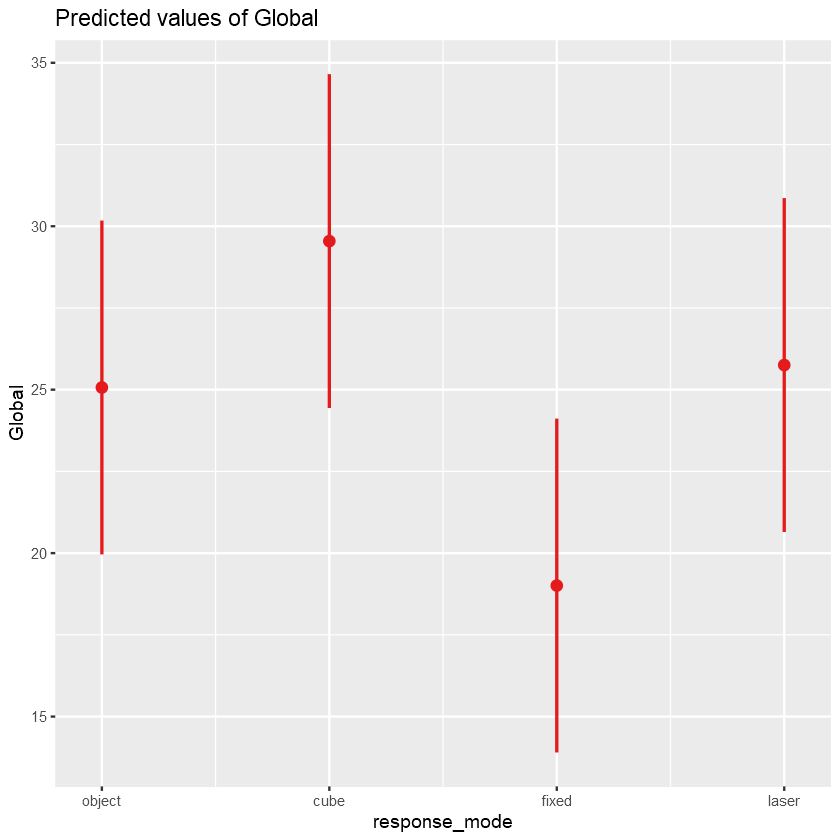

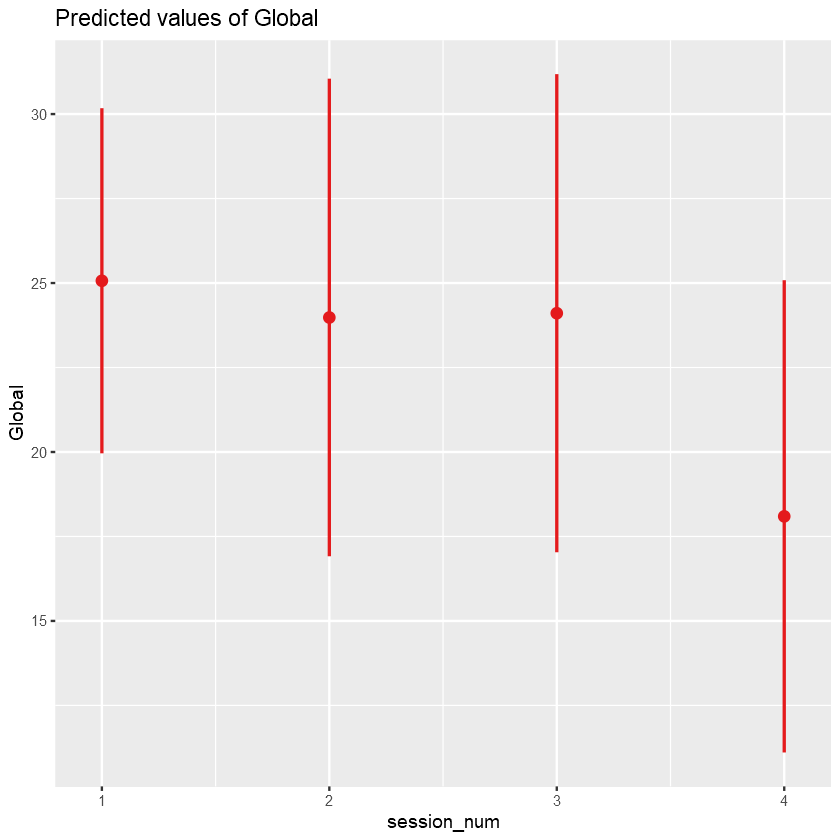

In [23]:
# Plot effects
plot_model(model.tlx, type='pred')